In [1]:
from __future__ import division
import matplotlib
from pylab import *
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import math

In [2]:
fontSize=16
#matplotlib.rcParams.update({"axes.formatter.limits": (-4,4), "svg.fonttype" : "none", 'font.family':'MathJax_SansSerif', 'font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,'text.usetex':False,'text.latex.preamble':[r'\usepackage{sansmath}',r'\sansmath']})
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4), "svg.fonttype" : "none", 'pdf.fonttype':42,'font.family':'DejaVu Sans','font.sans-serif':'Helvetica','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,'text.usetex':False,'text.latex.preamble':[r'\usepackage{sansmath}',r'\sansmath']})
plotStyles={"markersize":8,"markeredgewidth":1.0,"linewidth":3.0}
stepStyles={"markersize":20,"markeredgewidth":3.0,"linewidth":3.0,"where":"post"}
barStyles={"width":0.65, "linewidth":0, "align":"center"}

/Users/turtle/anaconda3/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


## 3' end binding

In [3]:
def term1(tau,N,c,k,denom):
    S = 0;
    for n in range(0,N+1):
        S += (N-n)*(N-n+1)*(2*N+n+1)/6*(k*tau)**n/np.math.factorial(n); 
    return S*c/k*np.exp(-k*tau)/denom

def denominator(N,c,k):
    return (c/k)**2*(N*(N+1)/2)**2

In [4]:
import decimal
decimal.getcontext().prec = 100

term1 = np.vectorize(term1)

In [5]:
from scipy.optimize import curve_fit

def my_func(tau,c,k):
    S = 0;
    denom = (c/k)**2*(N*(N+1)/2)**2; 
    for n in range(0,N+1):
        S = S+(N-n)*(N-n+1)*(2*N+n+1)/6*(k*tau)**n/np.math.factorial(n);
    return S*c/k*np.exp(-k*tau)/denom

my_func = np.vectorize(my_func)

### Varying parameters

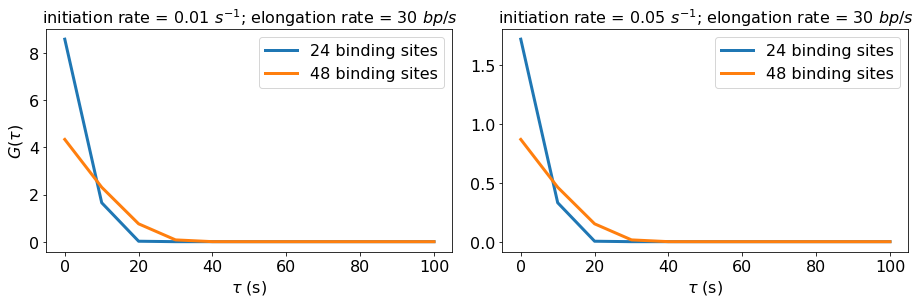

In [11]:
plt.rcParams["figure.figsize"] = (13,4.5)
plt.subplot(1,2,1)
plt.title(r'initiation rate = 0.01 $s^{-1}$; elongation rate = 30 $bp/s$')
plt.xlabel(r'$\tau$ (s)')
plt.ylabel(r'$G(\tau)$')
c = 0.01;
k = 30.0/19.0;
tau = np.linspace(0,100,11);
plt.plot(tau, term1(tau,24,c,k,denominator(24,c,k)), label='24 binding sites',**plotStyles);
plt.plot(tau, term1(tau,48,c,k,denominator(48,c,k)), label='48 binding sites',**plotStyles);
#plt.plot(tau, term1(tau,96,c,k,denom), label='96 binding sites',**plotStyles);
legend()

plt.subplot(1,2,2)
plt.title(r'initiation rate = 0.05 $s^{-1}$; elongation rate = 30 $bp/s$')
plt.xlabel(r'$\tau$ (s)')
c = 0.05;
k = 30.0/19.0;
plt.plot(tau, term1(tau,24,c,k,denominator(24,c,k)), label='24 binding sites',**plotStyles);
plt.plot(tau, term1(tau,48,c,k,denominator(48,c,k)), label='48 binding sites',**plotStyles);
#plt.plot(tau, term1(tau,96,c,k,denom), label='96 binding sites',**plotStyles);
legend()

tight_layout()

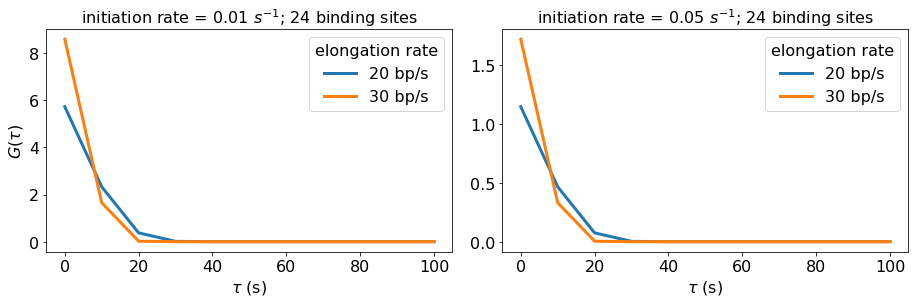

In [12]:
plt.rcParams["figure.figsize"] = (13,4.5)
plt.subplot(1,2,1)
plt.title(r'initiation rate = 0.01 $s^{-1}$; 24 binding sites')
plt.xlabel(r'$\tau$ (s)')
plt.ylabel(r'$G(\tau)$')
c = 0.01;
N = 24;
M = int(3075/19);
tau = np.linspace(0,100,11);
plt.plot(tau, term1(tau,N,c,20.0/19,denominator(N,c,20.0/19)), label='20 bp/s',**plotStyles);
plt.plot(tau, term1(tau,N,c,30.0/19,denominator(N,c,30.0/19)), label='30 bp/s',**plotStyles);
legend(title='elongation rate')

plt.subplot(1,2,2)
plt.title(r'initiation rate = 0.05 $s^{-1}$; 24 binding sites')
plt.xlabel(r'$\tau$ (s)')
c = 0.05;
M = int(3075/19);
N = 24;
plt.plot(tau, term1(tau,N,c,20.0/19,denominator(N,c,20.0/19)), label='20 bp/s',**plotStyles);
plt.plot(tau, term1(tau,N,c,30.0/19,denominator(N,c,30.0/19)), label='30 bp/s',**plotStyles);
legend(title='elongation rate')

tight_layout()

## Fit simulated data
* record total intensity every 10s
* 1000 replicates

In [16]:
def cal_autocorr(counts, tau, len_replicate, duration):
    numerator = np.array([]);
    F_i = np.mean(counts[:,0:duration-tau], axis=0);
    for i in range(0, len_replicate):
        n_tmp = counts[i,0:duration-tau]*counts[i,tau:];
        numerator = np.append(numerator, n_tmp);
    return np.mean(numerator)/np.mean(F_i*F_i)-1

In [17]:
def get_counts(filename, duration, verbose):
    fp = h5py.File(filename, "r");
    replicates=fp["/Simulations"].keys();
    n = 1; times=fp["/Simulations/%07d/SpeciesCountTimes"%n];
    
    counts = np.zeros((len(replicates), duration));
    for i,replicate in enumerate(replicates):
        counts[i,:] = np.sum(fp["/Simulations/%s/SpeciesCounts"%replicate][-duration:, range(4*num,5*num)], axis=1);

    autocorr = np.zeros(duration);
    for tau in range(0,duration):
        autocorr[tau] = cal_autocorr(counts, tau, len(replicates),duration)
        if verbose == 1:
            print(tau, autocorr[tau])
    return autocorr

Text(0, 0.5, 'Average total fluoresence')

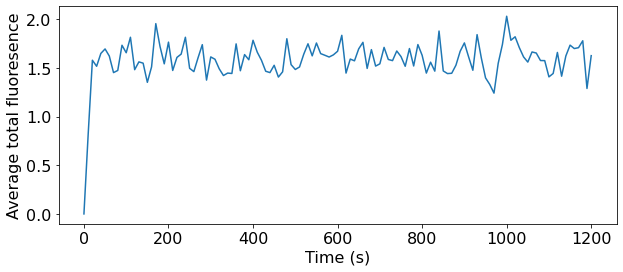

In [27]:
import h5py

num=24; 
myfile='3endbinding/noSC_3end.0.01.30.24.lm'

fp = h5py.File(myfile, "r");
replicates=fp["/Simulations"].keys();
times=fp["/Simulations/%07d/SpeciesCountTimes"%1];
mRNA=np.zeros(len(times))
for i,replicate in enumerate(replicates):
    counts=fp["/Simulations/%s/SpeciesCounts"%replicate];
    mRNA = mRNA + np.sum(counts[:,range(4*num,5*num)],axis=1);
mRNA = mRNA/len(replicates);
plt.rcParams["figure.figsize"] = (10,4)
plt.plot(times, mRNA)
plt.xlabel('Time (s)')
plt.ylabel('Average total fluoresence')

Text(0, 0.5, 'Average total fluoresence')

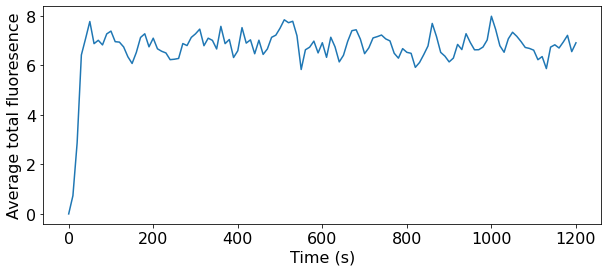

In [32]:
num=48; 
myfile='3endbinding/noSC_3end.0.01.30.48.lm'

fp = h5py.File(myfile, "r");
replicates=fp["/Simulations"].keys();
times=fp["/Simulations/%07d/SpeciesCountTimes"%1];
mRNA=np.zeros(len(times))
for i,replicate in enumerate(replicates):
    counts=fp["/Simulations/%s/SpeciesCounts"%replicate];
    mRNA = mRNA + np.sum(counts[:,range(4*num,5*num)],axis=1);
mRNA = mRNA/len(replicates);
plt.rcParams["figure.figsize"] = (10,4)
plt.plot(times, mRNA)
plt.xlabel('Time (s)')
plt.ylabel('Average total fluoresence')

In [33]:
num=24; 
filename = '3endbinding/noSC_3end.0.01.30.24.lm'
autocorr1 = get_counts(filename, 60, 0);

num=48; 
filename = '3endbinding/noSC_3end.0.01.30.48.lm'
autocorr2 = get_counts(filename, 60, 0);

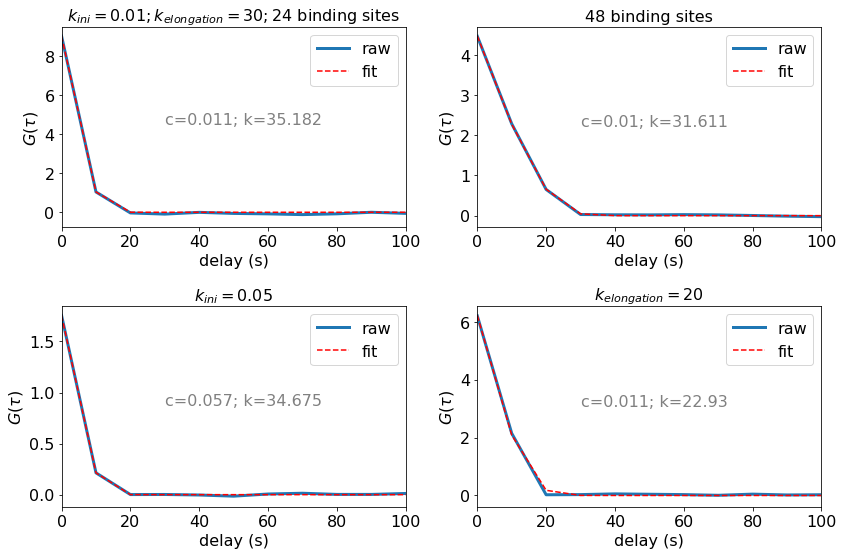

In [54]:
plt.rcParams["figure.figsize"] = (12,8)
subplot(2,2,1)
xdata = np.arange(0,600,10)
ydata = autocorr1

plt.title(r'$k_{ini}=0.01; k_{elongation}=30;$24 binding sites')
plt.plot(xdata, autocorr1, label='raw',**plotStyles);
N=24;
popt, pcov = curve_fit(my_func, xdata, autocorr1, p0=[0.05,2],maxfev=10000)
plt.plot(xdata, my_func(xdata,*popt),'r--',label='fit')
plt.text(30,0.5*max(autocorr1), 'c='+str(round(popt[0],3))+'; k='+str(round(popt[1]*19,3)),color='gray')
plt.ylabel(r'$G(\tau)$'); plt.xlabel('delay (s)'); 
plt.xlim(0,100)
plt.legend()

subplot(2,2,2)
xdata = np.arange(0,600,10)
ydata = autocorr1

plt.title(r'48 binding sites')
plt.plot(xdata, autocorr2, label='raw',**plotStyles);
N=48;
popt, pcov = curve_fit(my_func, xdata, autocorr2, p0=[0.05,2],maxfev=10000)
plt.plot(xdata, my_func(xdata,*popt),'r--',label='fit')
plt.text(30,0.5*max(autocorr2), 'c='+str(round(popt[0],3))+'; k='+str(round(popt[1]*19,3)),color='gray')
plt.ylabel(r'$G(\tau)$'); plt.xlabel('delay (s)'); 
plt.xlim(0,100)
plt.legend()

subplot(2,2,3)
xdata = np.arange(0,600,10)
ydata2 = autocorr3

plt.title(r'$k_{ini}=0.05$')
plt.plot(xdata, ydata2, label='raw',**plotStyles);
N=24;
popt, pcov = curve_fit(my_func, xdata, ydata2, p0=[0.01,1],maxfev=10000)
#plt.plot(xdata, my_func(xdata,0.05,30.0/19),'r--',label='fit')
plt.plot(xdata, my_func(xdata,*popt),'r--',label='fit')
plt.text(30,0.5*max(ydata2), 'c='+str(round(popt[0],3))+'; k='+str(round(popt[1]*19,3)),color='gray')
plt.ylabel(r'$G(\tau)$'); plt.xlabel('delay (s)'); 
plt.xlim(0,100)
plt.legend()

subplot(2,2,4)
xdata = np.arange(0,600,10)
ydata2 = autocorr4

plt.title(r'$k_{elongation}=20$')
plt.plot(xdata, ydata2, label='raw',**plotStyles);
N=24;
popt, pcov = curve_fit(my_func, xdata, ydata2, p0=[0.01,2],maxfev=10000)
plt.plot(xdata, my_func(xdata,*popt),'r--',label='fit')
plt.text(30,0.5*max(ydata2), 'c='+str(round(popt[0],3))+'; k='+str(round(popt[1]*19,3)),color='gray')
plt.ylabel(r'$G(\tau)$'); plt.xlabel('delay (s)'); 
plt.xlim(0,100)
plt.legend()


plt.tight_layout()

In [40]:
num=24; 
filename = '3endbinding/noSC_3end.0.05.30.24.lm'
autocorr3 = get_counts(filename, 60, 0);

In [43]:
num=24; 
filename = '3endbinding/noSC_3end.0.01.20.24.lm'
autocorr4 = get_counts(filename, 60, 0);